# Solution analytique en tube

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib
matplotlib.rcParams['text.usetex'] = True
import copy
import os, sys
from string import Template
import time
from IPython.display import display
import math

# See Marfaing, O., Guingo, M., Laviéville, J., Bois, G., Méchitoua, N., Mérigoux, N., & Mimouni, S. (2016). An analytical relation for the void fraction distribution in a fully developed bubbly flow in a vertical pipe. Chemical Engineering Science, 152, 579-585.

In [ ]:
from trustutils import run 
from trustutils import visit
from trustutils.jupyter import plot

run.TRUST_parameters()

In [3]:
sondes = {"Pipe":{}, "Channel2D":{}, "Channel3D":{}}


n_seg_sonde = 40
r_tube = 0.019

tab_name_sondes = ["vitesse_liquide_eau",
                   "vitesse_gaz_air",
                   "alpha_gaz_air",
                   "pression",
                   "dp",
                   "lift",
                   "disp",
                   "vorticite"
                  ]

x_0 = r_tube/(2*n_seg_sonde)*np.cos(np.pi*.5/360)
y_0 = r_tube/(2*n_seg_sonde)*np.sin(np.pi*.5/360)

x_wall = r_tube*(2*n_seg_sonde-1)/(2*n_seg_sonde)*np.cos(np.pi*.5/360)
y_wall = r_tube*(2*n_seg_sonde-1)/(2*n_seg_sonde)*np.sin(np.pi*.5/360)

z_sonde = 1.49

str_sonde = " "
for name_sonde in tab_name_sondes:
    str_sonde += f" {name_sonde} {name_sonde} periode 1.e-2 segment {n_seg_sonde} {x_0} {y_0} {z_sonde} {x_wall} {y_wall} {z_sonde}  \n"

sondes["Pipe"]["PolyMAC"],sondes["Channel3D"]["PolyMAC"],sondes["Channel3D"]["VDF"]  = str_sonde, str_sonde, str_sonde

str_sonde = " "
for name_sonde in tab_name_sondes:
    str_sonde += f" {name_sonde} {name_sonde} periode 1.e-2 segment {n_seg_sonde} {r_tube/(2*n_seg_sonde)} {z_sonde} {r_tube*(2*n_seg_sonde-1)/(2*n_seg_sonde)} {z_sonde}  \n"

sondes["Pipe"]["VDF"],sondes["Channel2D"]["PolyMAC"],sondes["Channel2D"]["VDF"]  = str_sonde, str_sonde, str_sonde


In [10]:
#Create the calculation cases

force_recalculation = True 

# Refinement
geometry   = [ "Pipe", "Channel2D", "Channel3D", ]
med_file   = {  "VDF" : "",  "PolyMAC" : "1_tube_analytique.med" }
name_mesh  = { "Pipe" : { "PolyMAC" : "read_med { domain dom mesh mesh file 1_tube_analytique.med }" ,
                          "VDF" : "Mailler dom { Pave tube  { Origine 0. 0. Nombre_de_Noeuds 41 201 Longueurs  0.019 1.5 } { bord symetrie    X = 0   0 <= Y <= 1.5  bord top   Y = 1.5   0 <= X <= 0.019  bord bottom    Y = 0   0 <= X <= 0.019 bord wall   X = 0.019 0 <= Y <= 1.5 } } "},
               "Channel2D" : { "PolyMAC" : "Mailler dom { Pave tube  { Origine 0. 0. Nombre_de_Noeuds 41 201 Longueurs  0.019 1.5 } { bord symetrie    X = 0   0 <= Y <= 1.5  bord top   Y = 1.5   0 <= X <= 0.019  bord bottom    Y = 0   0 <= X <= 0.019 bord wall   X = 0.019 0 <= Y <= 1.5 } } " ,
                               "VDF" : "Mailler dom { Pave tube  { Origine 0. 0. Nombre_de_Noeuds 41 201 Longueurs  0.019 1.5 } { bord symetrie    X = 0   0 <= Y <= 1.5  bord top   Y = 1.5   0 <= X <= 0.019  bord bottom    Y = 0   0 <= X <= 0.019 bord wall   X = 0.019 0 <= Y <= 1.5 } } "},
               "Channel3D" : { "PolyMAC" : "Mailler dom { Pave tube  { Origine 0. 0. 0. Nombre_de_Noeuds 41 2 201  Longueurs  0.019 0.001 1.5  } { bord symetrie    X = 0   0 <= Y <= 0.001 0 <= Z <= 1.5  bord symetrie   Y = 0. 0 <= X <= 0.019   0 <= Z <= 1.5   bord symetrie  Y = 0.001 0 <= X <= 0.019   0 <= Z <= 1.5   bord top   Z = 1.5   0 <= X <= 0.019  0 <= Y <= 0.001 bord bottom    Z = 0   0 <= X <= 0.019  0 <= Y <= 0.001 bord wall   X = 0.019  0 <= Y <= 0.001 0 <= Z <= 1.5  } } polyedriser dom " ,
                               "VDF" : "Mailler dom { Pave tube  { Origine 0. 0. 0. Nombre_de_Noeuds 41 2 201  Longueurs  0.019 0.001 1.5  } { bord symetrie    X = 0   0 <= Y <= 0.001 0 <= Z <= 1.5  bord symetrie   Y = 0. 0 <= X <= 0.019   0 <= Z <= 1.5   bord symetrie  Y = 0.001 0 <= X <= 0.019   0 <= Z <= 1.5   bord top   Z = 1.5   0 <= X <= 0.019  0 <= Y <= 0.001 bord bottom    Z = 0   0 <= X <= 0.019  0 <= Y <= 0.001 bord wall   X = 0.019  0 <= Y <= 0.001 0 <= Z <= 1.5  } }  "}
             }         
#no VDF for now : problem in velocity derivative
#schema = { "VDF" : " vdf  dis option_vdf { all_options } ", "PolyMAC" : " PolyMAC_P0  dis option_PolyMAC_P0 { traitement_axi } " }
schema = { "PolyMAC" : " PolyMAC_P0  dis option_PolyMAC_P0 { traitement_axi } " }
dimension = { "Pipe" :{ "VDF" : 2,  "PolyMAC" : 3}, "Channel2D" :{ "VDF" : 2,  "PolyMAC" : 2}, "Channel3D" :{ "VDF" : 3,  "PolyMAC" : 3} }
bidim_axi = { "Pipe" :{ "VDF" : "bidim_axi",  "PolyMAC" : " "}, "Channel2D" :{ "VDF" : " ",  "PolyMAC" : " "}, "Channel3D" :{ "VDF" : " ",  "PolyMAC" : " "} }
nrad = { "VDF" : 40,  "PolyMAC" : 40}
#solveur = { "ICE" : "", "SETS" : " 	facsec_diffusion_for_sets 100 " }
solveur = { "SETS" : " 	facsec_diffusion_for_sets 100 " } # Only SETS for fast run on TRUST validation
paroi = { "VDF" : " symetrie ",  "PolyMAC" : " paroi "}
paroi_adiabatique = { "VDF" : " symetrie ",  "PolyMAC" : " paroi_adiabatique "}

name_geom = {}
name_conf = {}

# Numerical parameters
facsec  = 1
tmax    = 2
nb_pas_dt_max = '100000'
seuil_statio  = '1.e-3'
number_of_partitions = {"Channel2D_PolyMAC_SETS" : 2, "Channel3D_PolyMAC_SETS" : 4, "Pipe_PolyMAC_SETS":8}

#Physical quantities
u_0 = 20000*1.e-6/0.038 #Re 20000
alpha_cible = 0.02

#Turbulent quantities
D_h = 0.038
CI_om = u_0/D_h
CI_k  = 0.01*u_0**2
        
#Two-phase quantities
Cd = .1
Cl = 0.03
D_td_star = 0.03
db = 0.0025
Cw1 = -.1
Cw2 = .147
u_r = np.sqrt(4.*db/(3*Cd)*9.81)
alpha_entree = alpha_cible *(u_0+u_r)/u_0

build_dir = run.BUILD_DIRECTORY
#build_dir = "/volatile/catB/cr268029/trust/Validation/Rapports_automatiques/Verification/Multiphase/Tube_solution_analytique/build"

for g in geometry:
    for s in schema.keys() :
        for solv in solveur.keys() :
            name = f"{g}_{s}_{solv}"
            name_geom[name] = g
            name_conf[name] = f"{s}_{solv}"


if force_recalculation or not os.path.exists(f'{build_dir}'):
    print('Recalculation running..')
    run.reset()
    for g in geometry:
        for s in schema.keys() :
            for solv in solveur.keys() :
                name = f"{g}_{s}_{solv}"

                substitutions_dict = {"dimension" : dimension[g][s],
                                        "bidim_axi" : bidim_axi[g][s],
                                        "name_mesh" : f'{name_mesh[g][s]}' ,
                                        "schema" : schema[s],

                                        "tmax": str(tmax),                                  
                                        "facsec" : str(facsec) ,
                                        "nb_pas_dt_max" : nb_pas_dt_max ,
                                        "seuil_statio" : seuil_statio ,
                                        "solveur" : solv ,
                                        "facsec_diffusion_for_sets" : solveur[solv] ,
                                                                                                    
                                        "u_0"  : f"{2*dimension[g][s]} {''.join([ ' 0 ' for i in range(2*(dimension[g][s]-1))])} {u_0} {u_0} " ,
                                        "grav"   : f"{2*dimension[g][s]} {''.join([ ' 0 ' for i in range(2*(dimension[g][s]-1))])} -9.81 -9.81 " ,
                                        "alpha_l0" : str(1-alpha_entree) ,
                                        "alpha_v0" : str(alpha_entree) ,

                                        "paroi_adiabatique" : paroi_adiabatique[s],
                                        "paroi" : paroi[s],

                                        "sondes" : sondes[g][s],
                                                    
                                    }

                tc = run.addCaseFromTemplate("jdd.data",targetDirectory=f"{name}",dic=substitutions_dict,nbProcs=number_of_partitions[name])
                if (med_file[s]!=""):
                    os.system(f'cp {build_dir}/{med_file[s]} {build_dir}/{name}/{med_file[s]}')

                if number_of_partitions[name] > 1:
                    tc.partition()
    run.printCases()
    run.runCases()
    display(run.tablePerf())

else:
    print('No recalculation, reusing old results!')

No recalculation, reusing old results!


In [11]:
def loadText(data, index_column=0, nb_column=-1, transpose=True, dtype="float", skiprows=0):
        
    if nb_column == -1:
        nb = None
    else:
        nb = index_column + nb_column

    try:
        if transpose:
            matrix = np.loadtxt(f'{build_dir}/{data}', dtype=dtype, skiprows=skiprows).T[index_column:nb]
        else:
            matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)[index_column:nb]
    except:
        matrix = np.loadtxt(data, dtype=dtype, skiprows=skiprows)        
        
    return matrix


In [12]:
## Loading simulation results

############# results : sim[config][debit air][raf][position]
#############         columns : ['y/h'] ['vxl'] ['vyl'] ['vxg'] ['vyg'] ['k'] ['alp'] ['DB']
#############                   ["diff"] ["conv"] ["press"] ["grav"] ["drag"] ["lift"] ["disp"] ["lub"]
#############               nb : end column name with lx for forces
############# sim name : tab_name [config][debit air][raf]
############# sim label: tab_label[config][debit air][raf]
############# convergence :  dt_ev[config][debit air][raf]
#############         columns : ['time']['dt']['facsec']['residu']['dt_stab']['vitl']['vitg']['alphal']['alphag']['Tl']['Tg']['diss']['k'] 

sim      =  {  }
dt_ev    = {  }

for s in schema.keys() :
    for g in geometry:
        for solv in solveur.keys() :
            name = f"{g}_{s}_{solv}"

            par = ""
            if number_of_partitions[name] > 1 : par = "PAR_"

            dt_ev[name] = pd.read_csv(f"{build_dir}/{name}/{par}jdd.dt_ev", sep="\t")
            dt_ev[name] = dt_ev[name].iloc[:,:13]
            dt_ev[name].columns = ['time', 'dt', 'facsec', 'residu', 'dt_stab', 'vitl', 'vitg', 'alphal', 'alphag', 'Tl', 'Tg', 'diss', 'k']               

            sim[name] = pd.DataFrame()
            sim[name]['r+']= np.linspace(1./(2*n_seg_sonde),1-1./(2*n_seg_sonde), 40)
            sim[name]['vxl']=np.array(loadText(f"{name}/{par}jdd_VITESSE_LIQUIDE_EAU.son"))[1::dimension[g][s],-1]
            sim[name]['vzl']=np.array(loadText(f"{name}/{par}jdd_VITESSE_LIQUIDE_EAU.son"))[dimension[g][s]::dimension[g][s],-1]
            sim[name]['vxg']=np.array(loadText(f"{name}/{par}jdd_VITESSE_GAZ_AIR.son"))[1::dimension[g][s],-1]
            sim[name]['vzg']=np.array(loadText(f"{name}/{par}jdd_VITESSE_GAZ_AIR.son"))[dimension[g][s]::dimension[g][s],-1]
            sim[name]['alp']=np.array(loadText(f"{name}/{par}jdd_ALPHA_GAZ_AIR.son"))[1::,-1]
            sim[name]['p']  =np.array(loadText(f"{name}/{par}jdd_PRESSION.son"))[1::,-1]
            sim[name]['dp'] =np.array(loadText(f"{name}/{par}jdd_DP.son"))[1::,-1]


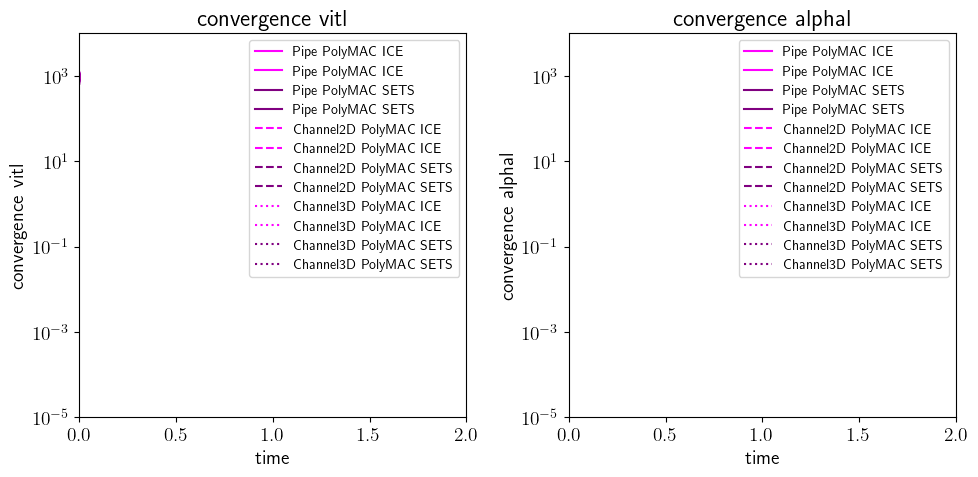

In [21]:
## plotting convergence

matplotlib.rcParams.update({'font.size': 14})

color_conf = { "VDF_ICE" : "red", "PolyMAC_ICE" : "magenta", "VDF_SETS" : "orange", "PolyMAC_SETS" : "purple"  }
marker_geom =  { "Pipe" : "-", "Channel2D" : "--", "Channel3D" : ":"}
linesize_geom =  { "Pipe" : 1, "Channel2D" : 2, "Channel3D" : 4}

fig = plt.figure(figsize = (10, 5))

name_phys = [ ["vitg"], ["alphag"]]

axs = fig.subplots(1, len(name_phys) )#, sharex=True, sharey=True)

for l in range(len(name_phys)): #phys
    for r in dt_ev.keys() :
        for lp in range(len(name_phys[l])) : #physique de la phase si multiphase
            axs[l].plot(dt_ev[r]["time"][::], dt_ev[r][name_phys[l][lp]][::], marker_geom[name_geom[r]], label = r.replace("_", " "), color = color_conf[name_conf[r]], linewidth = linesize_geom[name_geom[r]])

        axs[l].set_xlim(0,tmax)
        axs[l].set_ylim(float(seuil_statio)/100, 1e4)
        axs[l].set_yscale("log")
        axs[l].set_title("convergence "+name_phys[l][0] )
        axs[l].set_xlabel('time')
        axs[l].set_ylabel("convergence " + name_phys[l][0])
        axs[l].legend(prop={'size': 10})

plt.tight_layout()
#plt.savefig(f"{build_dir}/convergence.pdf")

In [14]:
# Calculer les résultats analytiques

alp = { }
alp_avg = {"Pipe" : 0.0175, "Channel" : 0.02}
ref_sim = {"Pipe" : "Pipe_PolyMAC_SETS", "Channel" : "Channel2D_PolyMAC_SETS"}
for gl in ref_sim.keys() :
    run = ref_sim[gl] 
    B = (u_0+u_r)/u_0
    l_sim = len(sim[run]["r+"] )

    rp  = sim[run]["r+"] 
    r   = rp * D_h/2.
    R   = np.zeros(l_sim) + D_h/2.
    y   = R-r
    y_st= 2*y/db
    r_st= 2*r/db
    R_st= 2*R/db
    Ur  = np.zeros(l_sim) + np.sqrt(4.*db/(3*Cd)*9.81) #Ug-Ul
    u_to= 0.1987*u_0*(u_0*D_h/(1.e-6))**(-1./8) #For liquid phase
    y_p = u_to * y / (1.e-6)
    Vl  = np.array(sim[run]["vzl"])   
    Vl_st=Vl/Ur
    P   = np.array(sim[run]["p"])
    P_st= P/(1000*Ur**2)
    P_stR=sim[run]["p"][l_sim-1]/(1000*Ur**2)
    Y_st= np.minimum(-Cw2/Cw1 + np.zeros(l_sim), y_st)

    alpl = B * np.exp( (np.log(Y_st)*Cw2+Cw1*Y_st-Cl*Vl_st+(P_st-P_stR))/D_td_star)

    alp[gl] = alpl / np.average(alpl)*alp_avg[gl]

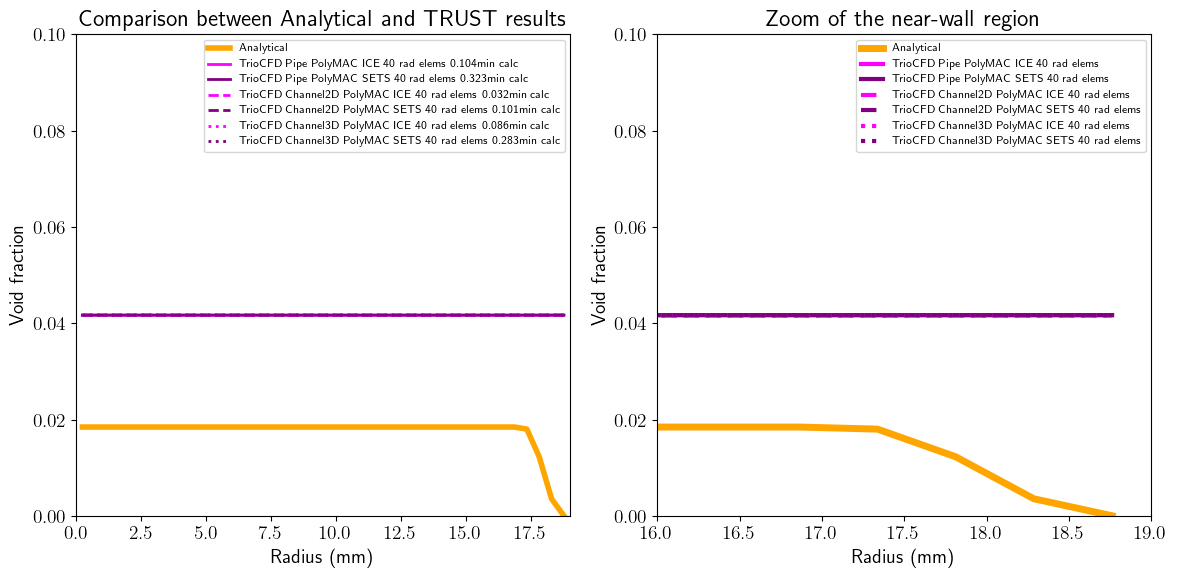

In [19]:
# Afficher tous les résultats de simu

# Colonnes : Titre, alpha, d, U (contient U_l et U_g), u'l
    
color_anap = "cyan"
color_anac = "blue"
marker_ana= "-"

plt.figure(figsize = (12,6))

plt.subplot(121)
plt.plot(r*1000, alp["Pipe"],    "-", color = color_anap, linewidth = 4, label = "Analytical Pipe")
plt.plot(r*1000, alp["Channel"], "-", color = color_anac, linewidth = 4, label = "Analytical Channel")

plt.xlim(0,19)
plt.ylim(0,.1)
for s in dt_ev.keys():
    par = ""
    if number_of_partitions[s] > 1 : par = "PAR_"

    f = os.open(f"{build_dir}/{s}/{par}jdd.perf", os.O_RDONLY)
    time_loc = str(float(os.read(f, 200).split()[3])/60*number_of_partitions[s])[:5]
    plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['alp'], marker_geom[name_geom[s]], label = f"TrioCFD {s.replace('_',' ')} {nrad[s.split('_')[1]]} rad elems {time_loc}min*proc calc", color = color_conf[name_conf[s]], linewidth = linesize_geom[name_geom[s]])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Void fraction")
plt.title("Comparison between Analytical and TRUST results")
    
plt.subplot(122)

plt.plot(r*1000, alp["Pipe"],    "-", color = color_anap, linewidth = 4, label = "Analytical Pipe")
plt.plot(r*1000, alp["Channel"], "-", color = color_anac, linewidth = 4, label = "Analytical Channel")

plt.xlim(16,19)
plt.ylim(0,.1)
for s in dt_ev.keys():
    plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['alp'], marker_geom[name_geom[s]], label = f"TrioCFD {s.replace('_',' ')} {nrad[s.split('_')[1]]} rad elems", color = color_conf[name_conf[s]], linewidth = linesize_geom[name_geom[s]])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Void fraction")
plt.title("Zoom of the near-wall region")

plt.tight_layout()

#plt.savefig(f"{build_dir}/Resultats_tube_analytique.pdf")


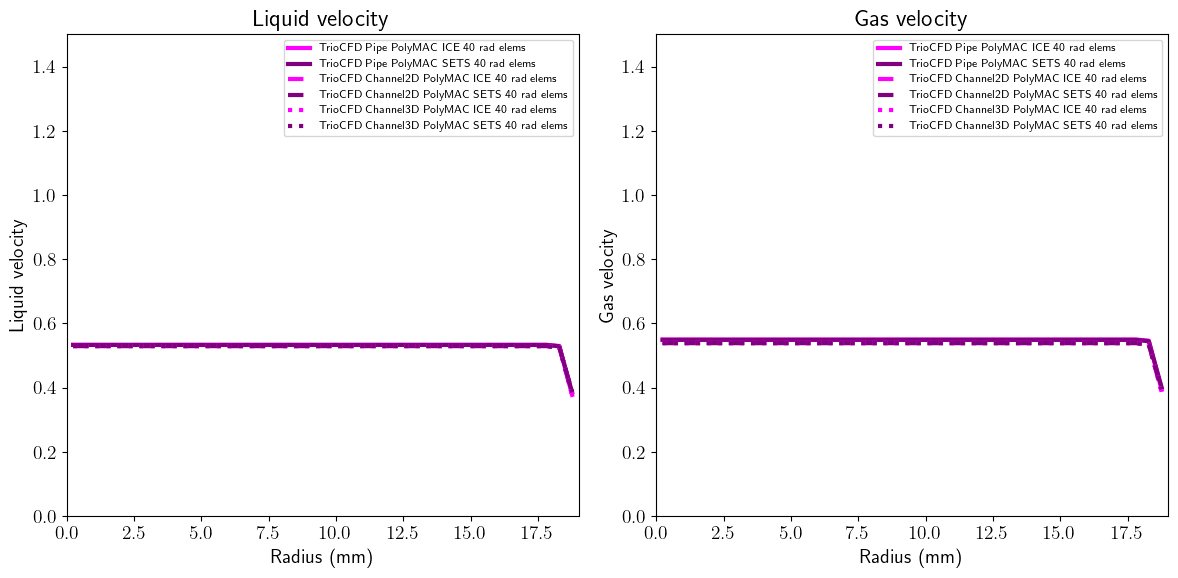

In [24]:
# Afficher tous les résultats de simu

# Colonnes : Titre, alpha, d, U (contient U_l et U_g), u'l

color_ana = "orange"
marker_ana= "-"

plt.figure(figsize = (12,6))

plt.subplot(121)
plt.xlim(0,19)
plt.ylim(0,1.5) 
for s in dt_ev.keys():
    plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['vzl'], marker_geom[name_geom[s]], label = f"TrioCFD {s.replace('_',' ')} {nrad[s.split('_')[1]]} rad elems", color = color_conf[name_conf[s]], linewidth = linesize_geom[name_geom[s]])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Liquid velocity")
plt.title("Liquid velocity")
    
plt.subplot(122)
plt.xlim(0,19)
plt.ylim(0,1.5)
for s in dt_ev.keys():
    plt.plot(np.array(sim[s]["r+"])*0.019*1000, sim[s]['vzg'], marker_geom[name_geom[s]], label = f"TrioCFD {s.replace('_',' ')} {nrad[s.split('_')[1]]} rad elems", color = color_conf[name_conf[s]], linewidth = linesize_geom[name_geom[s]])

plt.legend(fontsize = 8)
plt.xlabel("Radius (mm)")
plt.ylabel("Gas velocity")
plt.title("Gas velocity")

plt.tight_layout()

#plt.savefig(f"{build_dir}/Velocities.pdf")
